In [18]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.nn import LeakyReLU
from torch.utils.data import Dataset, DataLoader
from utils.vae import VAE
from PIL import Image

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])

class ShapeImageDataset(Dataset):
    def __init__(self, df_path, image_dir, transform=None):

        self.df = pd.read_csv(df_path) 
        self.image_dir = image_dir  
        self.transform = transform  
        self.emotion_columns = self.df.columns[7:]  

    def __len__(self):
        return min(len(self.df), len(os.listdir(self.image_dir)))

    def __getitem__(self, idx):

        adjusted_idx = idx + 1

        if adjusted_idx > len(self.df) or adjusted_idx > len(os.listdir(self.image_dir)):
            raise IndexError("Index out of range for dataset.")


        row = self.df.iloc[adjusted_idx - 1]
        image_path = os.path.join(self.image_dir, f"{adjusted_idx}.png")

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new("RGB", (200, 200), (255, 255, 255))

        if self.transform:
            image = self.transform(image)

        labels = row[self.emotion_columns].fillna(0).values.astype(np.float32)
        label_tensor = torch.tensor(labels, dtype=torch.float32)

        return image, label_tensor
    


In [21]:
path = "data/shapes.csv"   
image_dir = "data/images"  

dataset = ShapeImageDataset(df_path=path, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=80, shuffle=True)



In [22]:
class VAE(nn.Module):
    def __init__(self, latent_dim=28, image_size=(200, 200)):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.image_size = image_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        
        self.flattened_size = self.calculateFlattenedSize(image_size)
        
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc21 = nn.Linear(512, self.latent_dim)
        self.fc22 = nn.Linear(512, self.latent_dim)

        self.fc3 = nn.Linear(self.latent_dim, 512)
        self.fc4 = nn.Linear(512, self.flattened_size)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def calculateFlattenedSize(self, shape):
        x = torch.zeros(1, 3, *shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(torch.prod(torch.tensor(x.size())))

    def encoder(self, x, sentiment_vector):
        x = LeakyReLU(negative_slope=0.2)(self.bn1(self.conv1(x)))
        x = LeakyReLU(negative_slope=0.2)(self.bn2(self.conv2(x)))
        x = LeakyReLU(negative_slope=0.2)(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        h1 = LeakyReLU(negative_slope=0.2)(self.fc1(x))
        mu = self.fc21(h1) + sentiment_vector 
        logvar = self.fc22(h1)
        return mu, logvar

    def decoder(self, z):
        h3 = LeakyReLU(negative_slope=0.2)(self.fc3(z))
        h4 = LeakyReLU(negative_slope=0.2)(self.fc4(h3))
        batch_size = z.size(0)
        h4 = h4.view(batch_size, 128, 25, 25)

        x = LeakyReLU(negative_slope=0.2)(self.deconv1(h4))
        x = LeakyReLU(negative_slope=0.2)(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  
        return x

    def forward(self, x, sentiment_vector):
        mu, logvar = self.encoder(x, sentiment_vector)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    


In [23]:
def plotLoss(recon_x, x, mu, logvar):
    MSE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KL

losses = []



In [24]:
def trainVae(model, dataloader, optimizer, n_epochs=300):
    model.train()  
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for idx, (data, sentiment_vector) in enumerate(dataloader):
            data = data.to(device)
            sentiment_vector = sentiment_vector.to(device)
            
            optimizer.zero_grad()

            output, mean, logvar = model(data, sentiment_vector)

            loss = plotLoss(output, data, mean, logvar)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

            if idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        mean_loss = epoch_loss / len(dataloader)
        losses.append(mean_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}], Mean Loss: {mean_loss:.4f}")

        

Epoch [1/300], Batch [1/1], Loss: 3009845.7500
Epoch [1/300], Mean Loss: 3009845.7500
Epoch [2/300], Batch [1/1], Loss: 2974888.5000
Epoch [2/300], Mean Loss: 2974888.5000
Epoch [3/300], Batch [1/1], Loss: 2956280.0000
Epoch [3/300], Mean Loss: 2956280.0000
Epoch [4/300], Batch [1/1], Loss: 2942744.0000
Epoch [4/300], Mean Loss: 2942744.0000
Epoch [5/300], Batch [1/1], Loss: 2928835.5000
Epoch [5/300], Mean Loss: 2928835.5000
Epoch [6/300], Batch [1/1], Loss: 2915187.7500
Epoch [6/300], Mean Loss: 2915187.7500
Epoch [7/300], Batch [1/1], Loss: 2902884.2500
Epoch [7/300], Mean Loss: 2902884.2500
Epoch [8/300], Batch [1/1], Loss: 2891304.5000
Epoch [8/300], Mean Loss: 2891304.5000
Epoch [9/300], Batch [1/1], Loss: 2880147.0000
Epoch [9/300], Mean Loss: 2880147.0000
Epoch [10/300], Batch [1/1], Loss: 2867847.5000
Epoch [10/300], Mean Loss: 2867847.5000
Epoch [11/300], Batch [1/1], Loss: 2854821.7500
Epoch [11/300], Mean Loss: 2854821.7500
Epoch [12/300], Batch [1/1], Loss: 2853323.5000
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

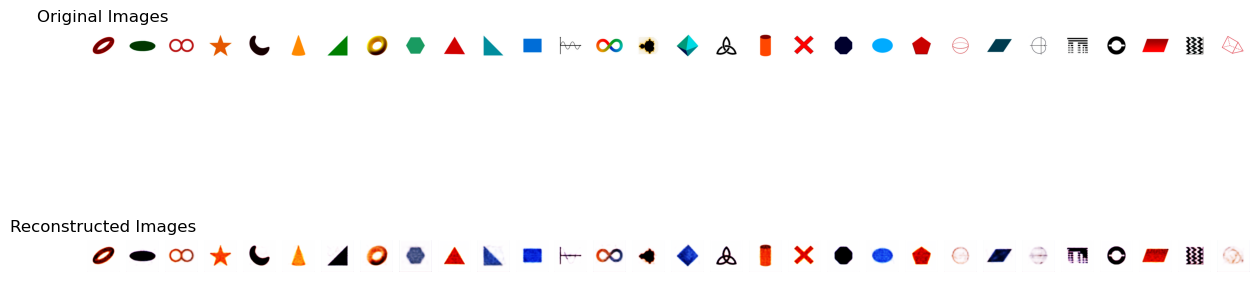

In [25]:
def visualizeSample(model, dataloader, n_samples=30):
    model.eval()  
    loader = iter(dataloader)
    
    images, sentiment_vectors = next(loader)  

    images = images.to(device)
    sentiment_vectors = sentiment_vectors.to(device)

    with torch.no_grad():
        output_images, _, _ = model(images, sentiment_vectors)

    images = images.cpu().numpy()
    output_images = output_images.cpu().numpy()

    fig, subplots = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

    for i in range(n_samples):
        subplots[0, i].imshow(images[i].transpose(1, 2, 0))  
        subplots[0, i].axis('off')

        subplots[1, i].imshow(output_images[i].transpose(1, 2, 0))  
        subplots[1, i].axis('off')

        subplots[0, 0].set_title('Original Images')
        subplots[1, 0].set_title('Reconstructed Images')

    plt.show()

def plotLossCurve(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training Loss')
    plt.grid(True)
    plt.show()

model = VAE(latent_dim=28).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  

trainVae(model, dataloader, optimizer, n_epochs=300)

visualizeSample(model, dataloader)

In [26]:
torch.save(model.state_dict(), "vae_model.pth")

print("Model saved as 'vae_model.pth'")

Model saved as 'vae_model.pth'
